In [1]:
import sys
sys.path.append('../../lib')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from blogdiffusion.refactor import *
from fastai.vision.all import *
from denoising_diffusion_pytorch import Unet
from pytorch_fid.inception import InceptionV3
from scipy import linalg

In [4]:
path = untar_data(URLs.CIFAR)

In [5]:
def get_inception_dls(path):
    bs=128
    return DataBlock((ImageBlock()),
              item_tfms=[Resize(299)],
              get_items=get_image_files,
              splitter=FuncSplitter(lambda *xs:False),
    ).dataloaders(path,bs=bs,val_bs=2*bs)

We don't care about the label here. 

In [151]:
torch.randn(1000).std(),(torch.rand(1000)-0.5).std()

(tensor(0.9616), tensor(0.2965))

(array([110., 106., 101., 102.,  96.,  96.,  96., 100., 106.,  87.]),
 array([-4.9947554e-01, -3.9967293e-01, -2.9987031e-01, -2.0006771e-01,
        -1.0026511e-01, -4.6250224e-04,  9.9340104e-02,  1.9914271e-01,
         2.9894531e-01,  3.9874792e-01,  4.9855053e-01], dtype=float32),
 <BarContainer object of 10 artists>)

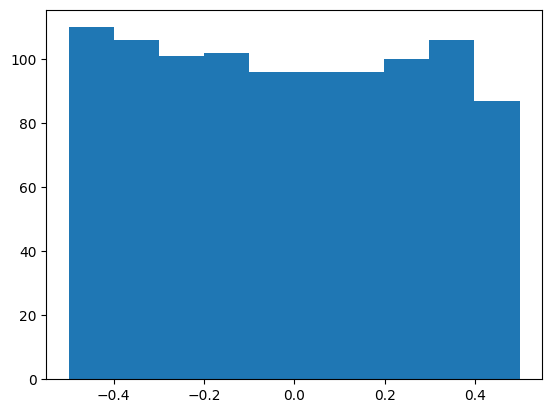

In [150]:
plt.hist((torch.rand(1000)-0.5))

(array([  7.,  11.,  44., 122., 213., 234., 198., 123.,  34.,  14.]),
 array([-3.4285753 , -2.7947857 , -2.1609962 , -1.5272068 , -0.89341724,
        -0.2596277 ,  0.3741618 ,  1.0079514 ,  1.6417408 ,  2.2755303 ,
         2.9093199 ], dtype=float32),
 <BarContainer object of 10 artists>)

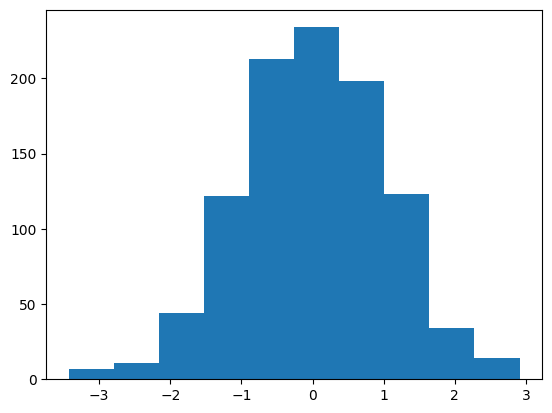

In [149]:
plt.hist(torch.randn(1000))

In [6]:
#|export
def _squared_mmd(x, y):
    def k(a,b): return (a@b.transpose(-2,-1)/a.shape[-1]+1)**3
    m,n = x.shape[-2],y.shape[-2]
    kxx,kyy,kxy = k(x,x), k(y,y), k(x,y)
    kxx_sum = kxx.sum([-1,-2])-kxx.diagonal(0,-1,-2).sum(-1)
    kyy_sum = kyy.sum([-1,-2])-kyy.diagonal(0,-1,-2).sum(-1)
    kxy_sum = kxy.sum([-1,-2])
    return kxx_sum/m/(m-1) + kyy_sum/n/(n-1) - 2*kxy_sum/m/n
     

def _calc_stats(feats):
    feats = feats.squeeze()
    return feats.mean(0),feats.T.cov()

def _calc_fid(m1,c1,m2,c2):
#     csr = _sqrtm_newton_schulz(c1@c2)
    csr = tensor(linalg.sqrtm(c1@c2, 256).real)
    return (((m1-m2)**2).sum() + c1.trace() + c2.trace() - 2*csr.trace()).item()
def _calc_kid(x, y, maxs=50):
    xs,ys = x.shape[0],y.shape[0]
    n = max(math.ceil(min(xs/maxs, ys/maxs)), 4)
    mmd = 0.
    for i in range(n):
        cur_x = x[round(i*xs/n) : round((i+1)*xs/n)]
        cur_y = y[round(i*ys/n) : round((i+1)*ys/n)]
        mmd += _squared_mmd(cur_x, cur_y)
    return (mmd/n).item()

In [135]:
_calc_stats(feats)[0].shape,_calc_stats(feats)[1].shape

(torch.Size([2048]), torch.Size([2048, 2048]))

In [ ]:
(m1**2+m2**2-2m1m2)

In [137]:
std1**2 + std2**2 - 2*sqrt(std1**2@std2**2)

torch.Size([128, 2048])

In [138]:
_calc_stats(feats)[1].shape

torch.Size([2048, 2048])

In [136]:
_calc_stats(feats)[1][:4,:4]

tensor([[0.0081, 0.0038, 0.0035, 0.0027],
        [0.0038, 0.0254, 0.0008, 0.0053],
        [0.0035, 0.0008, 0.0243, 0.0017],
        [0.0027, 0.0053, 0.0017, 0.0210]])

In [ ]:
m1**2-2m1m2+m2**2

In [124]:
((torch.randn(100,32)@torch.randn(100,32).transpose(-2,-1)/32+1)**3).shape

torch.Size([100, 100])

In [126]:
_squared_mmd(torch.randn(100,32),torch.rand(100,32))

tensor(0.9563)

In [7]:
class IncepWrap(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = InceptionV3(resize_input=True)
    def forward(self, x): 
        if x.shape[1]==1: x=x.repeat(1,3,1,1)
        return self.m(x)[0]

In [28]:
class ImageEval:
    def __init__(self, path,diffusion_dl, model=None):
        if model is None: self.model=IncepWrap()
        self.dls = get_inception_dls(path)
        self.learn=Learner(self.dls,self.model,loss_func=lambda x:1)
        self.feats = self.learn.get_preds(0)[0].cpu().float().squeeze()
        self.stats = _calc_stats(self.feats)

    def get_feats(self, samp):
        return self.learn.get_preds(dl=self.dls[1].new([*samp]))[0].cpu().float().squeeze()
    def _decode(self,samp):
        return self.diffusion_dl.decode(samp)

    def fid(self, samp,*args): return _calc_fid(*self.stats, *_calc_stats(self.get_feats(samp)))
    def kid(self, samp,*args): return _calc_kid(self.feats, self.get_feats(samp))

fid: https://www.youtube.com/watch?v=tTOcEm2l5tI&t=412s (5:30)

kid: https://www.youtube.com/watch?v=zFffYuDGslg (5:20)

In [33]:
im_eval=ImageEval(path,None)

In [10]:
bs=128
n_steps=1000
m=Unet(dim=192+192//8,channels=3,).cuda()
diffusion_transform = DiffusionSamplingTransform(DDPM_Q_Sampling(),Diffusion_P_Sampler(m,DDIM_P_Sampling()))
dls=DataBlock((ImageBlock(),
               TransformBlock(type_tfms=[Transform(enc=lambda o: TensorStep(o))]),
               ImageBlock()),
          n_inp=2,
          item_tfms=[Resize(32)],
          batch_tfms=(Normalize.from_stats(*cifar_stats),ToDiffusionTuple,LabelToNoise,diffusion_transform),
          get_items=get_image_files,
          get_x=[lambda x:x,
                 lambda x: torch.randint(1, n_steps, (1,), dtype=torch.long)],
          splitter=IndexSplitter(range(bs)),
).dataloaders(path,bs=bs,val_bs=2*bs)

/home/molly/miniconda3/envs/fastai/lib/python3.10/site-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


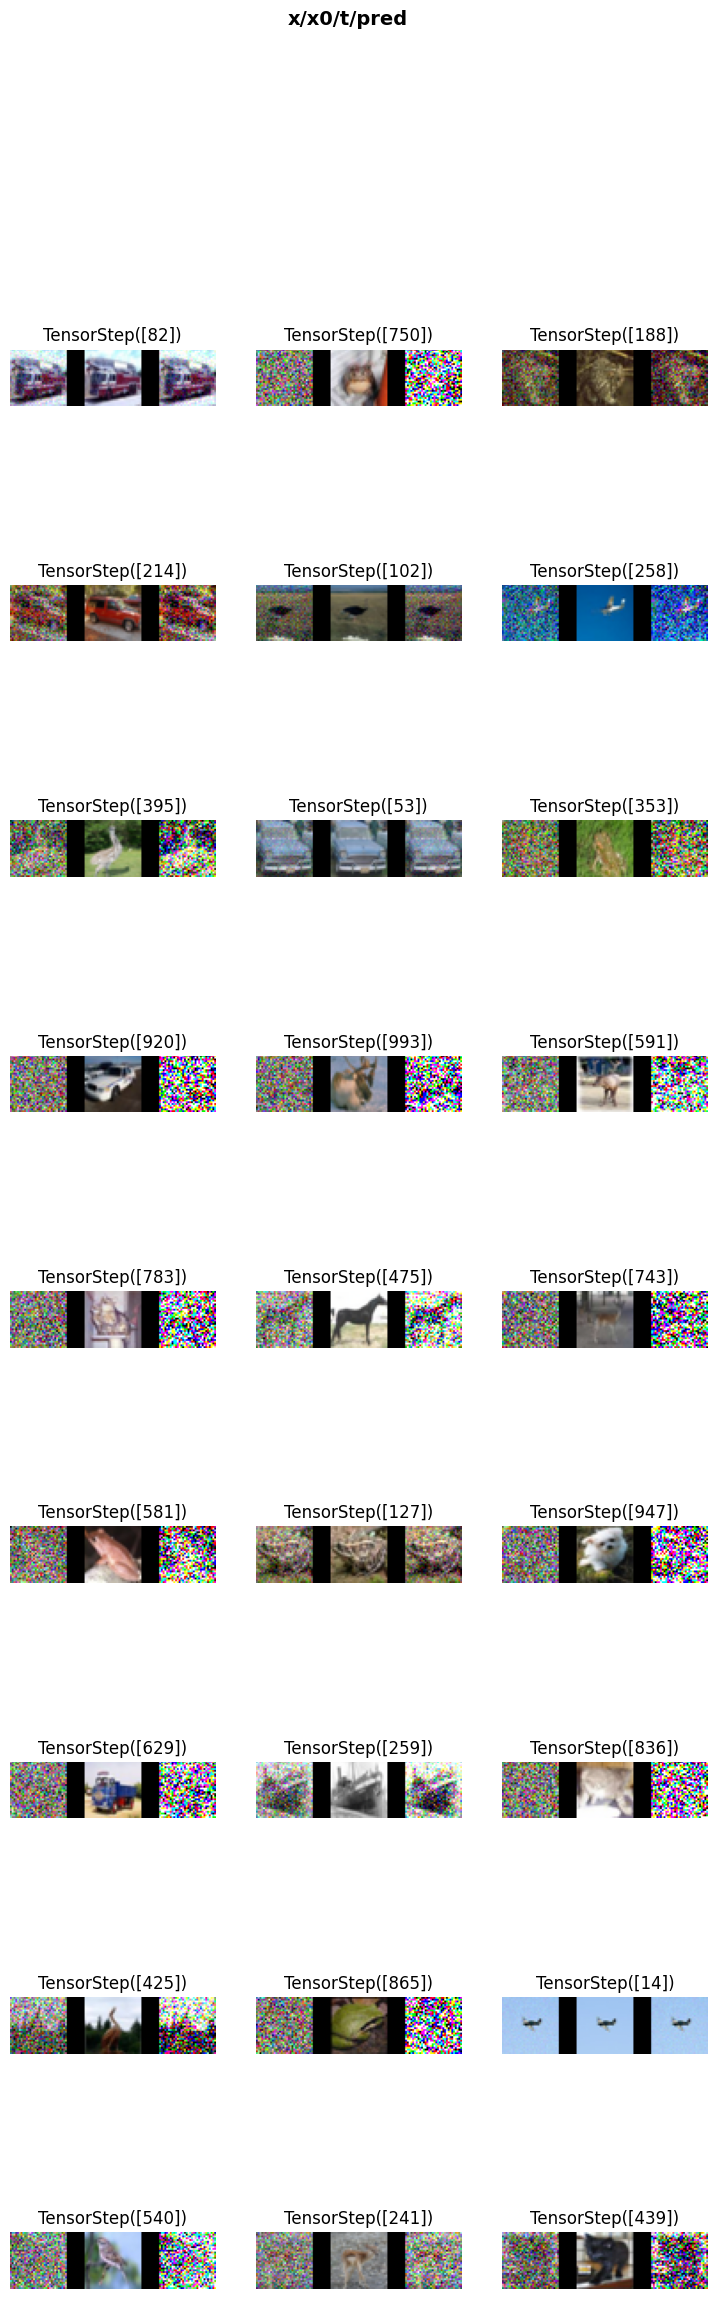

In [11]:
dls.show_batch()

In [12]:
learn = Learner(dls,m,MSELossFlat(),opt_func=Adam,cbs=[FlattenCallback])
learn = learn.to_fp16()
learn.fit_one_cycle(10,lr_max=2e-4,wd=1e-4)

epoch,train_loss,valid_loss,time
0,0.084370,0.069076,04:50
1,0.066831,0.043628,04:51
2,0.057644,0.067970,04:51
3,0.056255,0.064732,04:49
4,0.053987,0.062179,04:50
5,0.054337,0.053284,04:51
6,0.052907,0.071268,04:51
7,0.051084,0.067424,04:51
8,0.051939,0.056483,04:52
9,0.051351,0.047119,04:52


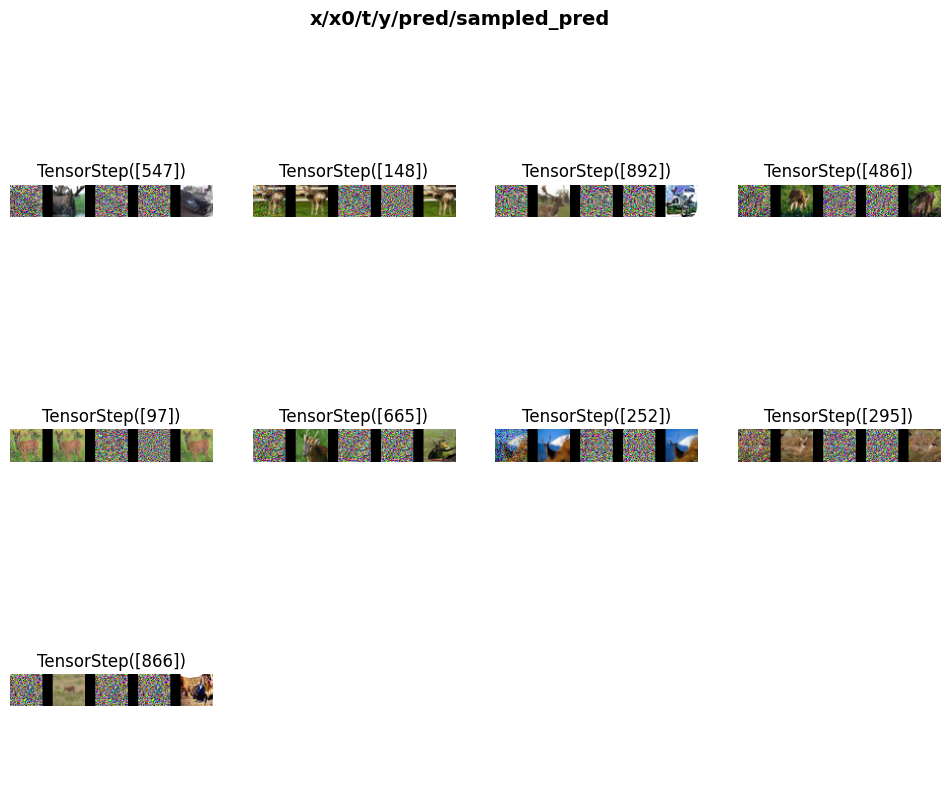

In [13]:
learn.show_results(show_noise=True)

We can get sample using p sample, then use decodes to convert it back into an image. 

/home/molly/miniconda3/envs/fastai/lib/python3.10/site-packages/torch/_tensor.py:1121: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


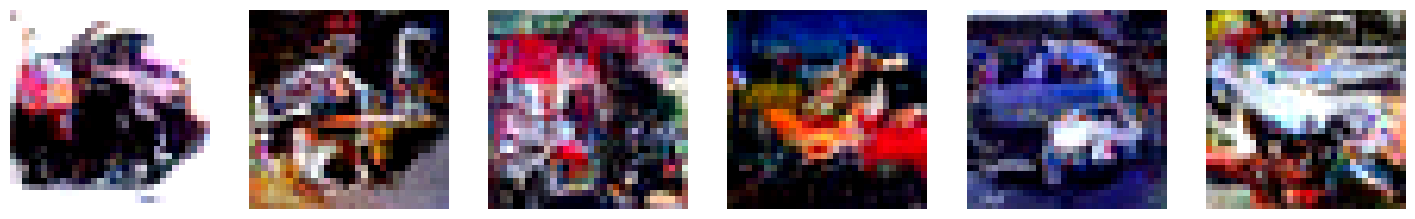

In [61]:
im=TensorImage(diffusion_transform.p_sample(torch.randn(128,3,32,32).cuda()))
im=dls[1].decode((im,torch.full([im.shape[0],1],999),torch.zeros_like(im)))[0]
show_images(im[:6])

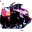

In [62]:
PILImage.create(im[0])

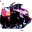

In [63]:
PILImage.create(im[0])

In [64]:
incep_img=im_eval.dls[1].new([(PILImage.create(im[0]),)]).one_batch()[0]
incep_img.shape

torch.Size([1, 3, 299, 299])

In [65]:
im_eval.dls[1].new([*incep_img]).one_batch().shape

torch.Size([1, 3, 299, 299])

In [130]:
im_eval.get_feats([(PILImage.create(im[0]),),(PILImage.create(im[1]),)]).shape

torch.Size([2, 2048])

My fid scores are horrible, which they should be, as I haven't spent a lot of time figuring out training. 

In [69]:
im_eval.fid([(PILImage.create(img),) for img in im])

215.73316955566406

In [70]:
im_eval.kid([(PILImage.create(img),) for img in im])

0.11808633804321289

In [131]:
feats=im_eval.get_feats([(PILImage.create(img),) for img in im])

In [132]:
feats.shape

torch.Size([128, 2048])

In [85]:
def _calc_fid_no_reduce(m1,c1,m2,c2):
#     csr = _sqrtm_newton_schulz(c1@c2)
    csr = tensor(linalg.sqrtm(c1@c2, 256).real)
    return ((m1-m2)**2)+ c1.diag() + c2.diag() - 2*csr.diag()

In [104]:
fid_not_reduced = _calc_fid_no_reduce(*_calc_stats(feats[:num_feats,:2]),*_calc_stats(im_eval.feats[:num_feats,:2]))

In [129]:
_calc_stats(feats)

(tensor([0.1106, 0.2069, 0.2973,  ..., 0.3641, 0.3173, 1.0371]),
 tensor([[ 0.0081,  0.0038,  0.0035,  ...,  0.0068,  0.0049,  0.0045],
         [ 0.0038,  0.0254,  0.0008,  ...,  0.0108,  0.0127,  0.0039],
         [ 0.0035,  0.0008,  0.0243,  ...,  0.0011,  0.0039, -0.0022],
         ...,
         [ 0.0068,  0.0108,  0.0011,  ...,  0.1226,  0.0327, -0.0016],
         [ 0.0049,  0.0127,  0.0039,  ...,  0.0327,  0.0596, -0.0146],
         [ 0.0045,  0.0039, -0.0022,  ..., -0.0016, -0.0146,  0.1695]]))

In [106]:
fid_not_reduced

tensor([0.0360, 0.0038])

In [91]:
im_eval.stats[1].shape

torch.Size([2048, 2048])

In [88]:
fid_not_reduced.shape

torch.Size([2048])

In [100]:
feats[:5,0].shape

torch.Size([5])

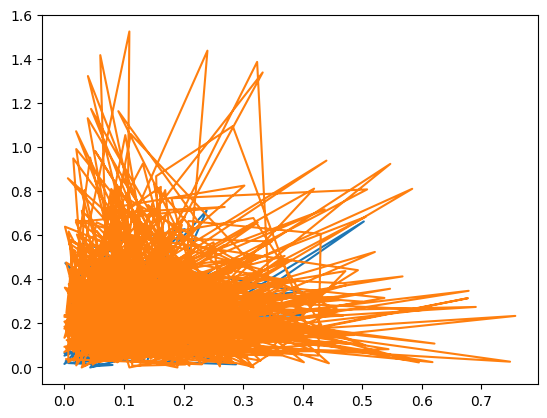

In [153]:
num_feats=1000
plt.plot(feats[:num_feats,0],feats[:num_feats,1])
plt.plot(im_eval.feats[:num_feats,0],im_eval.feats[:num_feats,1])

In [78]:
im_eval.feats

(tensor([0.0950, 0.2490, 0.2982,  ..., 0.4968, 0.3891, 0.6538]),
 tensor([[ 0.0116,  0.0019, -0.0003,  ...,  0.0082, -0.0008,  0.0017],
         [ 0.0019,  0.0447,  0.0005,  ...,  0.0051,  0.0054,  0.0003],
         [-0.0003,  0.0005,  0.0449,  ..., -0.0210,  0.0027,  0.0013],
         ...,
         [ 0.0082,  0.0051, -0.0210,  ...,  0.2149,  0.0135,  0.0092],
         [-0.0008,  0.0054,  0.0027,  ...,  0.0135,  0.1039, -0.0057],
         [ 0.0017,  0.0003,  0.0013,  ...,  0.0092, -0.0057,  0.1836]]))

In [ ]:
agfhgsahy

In [ ]:
from datasets import load_dataset

In [ ]:
dsd = load_dataset("fashion_mnist")

In [ ]:
bs=128
dls=DataBlock((ImageBlock()),
          splitter=FuncSplitter(lambda *xs:False),
          get_x=[lambda x:PILImage(x['image'])],
).dataloaders(dsd['train'],bs=bs,val_bs=2*bs,drop_last=False)

In [ ]:
sum_pixels=sum([b[0].sum((0,2,3)) for b in dls[0]])
num_pixels=len(dls[0])*dls.one_batch()[0][:,0].numel()
avg_pixels=sum_pixels/num_pixels
avg_pixels

In [ ]:
sum_pixels=sum([(b[0]**2).sum((0,2,3)) for b in dls[0]])
num_pixels=len(dls[0])*dls.one_batch()[0][:,0].numel()
avg_square_pixels=sum_pixels/num_pixels
avg_square_pixels

In [ ]:
var_pixels=avg_square_pixels-avg_pixels**2
var_pixels

In [ ]:
bs=128
dls=DataBlock((ImageBlock()),
          item_tfms=[Resize(32)],
          batch_tfms=(Normalize.from_stats(avg_pixels,var_pixels**.5)),
          splitter=RandomSplitter(),
          get_x=[lambda x:PILImage(x['image'])],
).dataloaders(dsd['train'],bs=bs,val_bs=2*bs)

In [ ]:
dls.one_batch()[0].mean(),dls.one_batch()[0].std(),

In [ ]:
plt.plot(logit(torch.linspace(0,1,100)))